## Re-gridding Vorticity Diagnostics

Coarse-graining code (FlowSieve python library) requires dignostics on a regular lat-lon grid. We use Xesmf library (https://xesmf.readthedocs.io/https://xesmf.readthedocs.io/) to re-grid diagnostics on a regular grid.  

In [1]:
import xarray as xr
import xesmf as xe
from xgcm import Grid
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ppdir = "/home/users/hkhatri/GFDL_Vorticity_Diag/"

ds = xr.open_dataset(ppdir + "OM4p25_JRA55_Vorticity_Budget_1958_2017_Mean.nc")

print(ds)

<xarray.Dataset>
Dimensions:       (xq: 1440, yq: 1080, yh: 1080, xh: 1440)
Coordinates:
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Data variables: (12/35)
    beta_V        (yq, xq) float64 ...
    BPT           (yq, xq) float64 ...
    Curl_Adv      (yq, xq) float64 ...
    Curl_taus     (yq, xq) float64 ...
    Curl_taub     (yq, xq) float64 ...
    Curl_diff     (yq, xq) float64 ...
    ...            ...
    hfgeou        (yh, xh) float32 ...
    sftof         (yh, xh) float32 ...
    wet           (yh, xh) float32 ...
    wet_c         (yq, xq) float32 ...
    wet_u         (yh, xq) float32 ...
    wet_v         (yq, xh) float32 ...


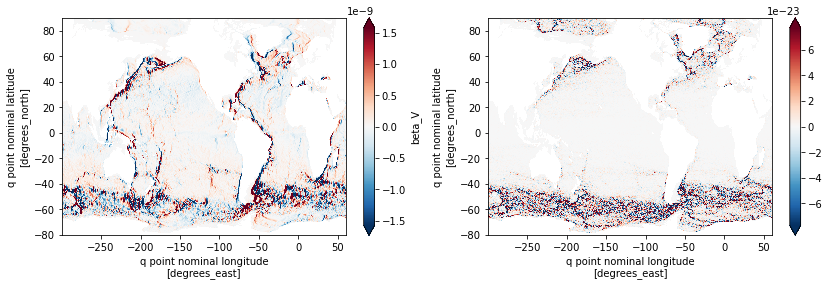

In [3]:
# Check the vorticity budget is closed gri-point-wise

fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
ds['beta_V'].plot(robust=True) # this is just noise

tmp = (ds['beta_V'] - ds['BPT'] - ds['Curl_Adv'] - ds['Curl_taus'] - ds['Curl_taub'] - ds['Curl_diff'] 
       - ds['Mass_flux'] - ds['Curl_dudt'] - ds['eta_dt'])

plt.subplot(1,2,2)
tmp.plot(robust=True) # this is just noise

In [4]:
# Check if the budget is conserved after interpolating to tracer grid points 

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])
var_list = ['beta_V', 'BPT', 'Curl_Adv', 'Curl_taus', 'Curl_taub', 'Curl_diff', 'Mass_flux', 'Curl_dudt', 'eta_dt']

ds_inp = xr.Dataset()
for var in var_list:
    ds_inp[var] = grid.interp(grid.interp(ds[var], 'X',  boundary='fill'), 'Y',  boundary='fill')

print(ds_inp)

<xarray.Dataset>
Dimensions:    (xh: 1440, yh: 1080)
Coordinates:
  * xh         (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh         (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Data variables:
    beta_V     (yh, xh) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    BPT        (yh, xh) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_Adv   (yh, xh) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_taus  (yh, xh) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_taub  (yh, xh) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_diff  (yh, xh) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Mass_flux  (yh, xh) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_dudt  (yh, xh) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    eta_dt     (yh, xh) float64 nan nan nan nan nan nan ... nan nan nan nan nan


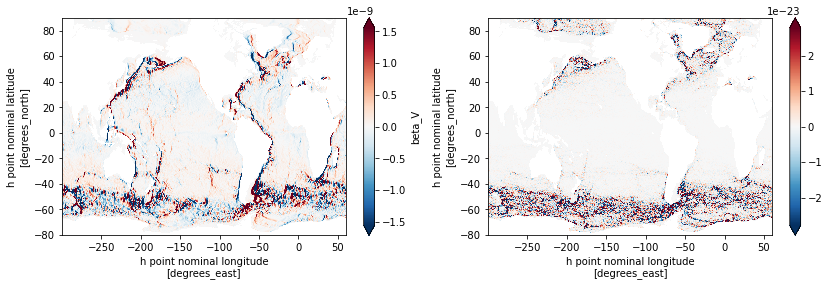

In [5]:
fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
ds_inp['beta_V'].plot(robust=True) # this is just noise

tmp = (ds_inp['beta_V'] - ds_inp['BPT'] - ds_inp['Curl_Adv'] - ds_inp['Curl_taus'] - ds_inp['Curl_taub'] - ds_inp['Curl_diff'] 
       - ds_inp['Mass_flux'] - ds_inp['Curl_dudt'] - ds_inp['eta_dt'])

plt.subplot(1,2,2)
tmp.plot(robust=True) # this is just noise

### Re-gridding 

Here, we compare two methods for re-grdigging,
1. Bilinear
2. Conserved (requires lat/lon values at corners on native grid)

In [3]:
## First check with bilinear

ds_out = xe.util.grid_global(1., 1.) # xesmf inbuit function

print(ds_out)

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, y_b: 181, x_b: 361)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) float64 -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*


In [5]:
grid_model = xr.open_dataset(ppdir + 'ocean_monthly.static.nc')

grid_model = grid_model.get(['geolon', 'geolon_c', 'geolat', 'geolat_c'])
grid_model = grid_model.rename({'geolon': 'lon','geolat': 'lat','geolon_c': 'lon_b','geolat_c': 'lat_b',})

print(grid_model)

<xarray.Dataset>
Dimensions:  (yh: 1080, xh: 1440, yq: 1081, xq: 1441)
Coordinates:
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * xq       (xq) float64 -299.8 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * yq       (yq) float64 -80.43 -80.35 -80.27 -80.19 ... 89.68 89.78 89.89 90.0
Data variables:
    lon      (yh, xh) float32 ...
    lon_b    (yq, xq) float32 ...
    lat      (yh, xh) float32 ...
    lat_b    (yq, xq) float32 ...
Attributes:
    external_variables:  areacello areacello


In [6]:
%time regrid_ds = xe.Regridder(grid_model, ds_out, 'bilinear', periodic=True)

CPU times: user 45.5 s, sys: 4.72 s, total: 50.2 s
Wall time: 50.9 s


In [9]:
%time ds_regrid_bilin1 = regrid_ds(ds_inp)

print(ds_regrid_bilin1)

CPU times: user 2.05 s, sys: 97.7 ms, total: 2.15 s
Wall time: 2.21 s
<xarray.Dataset>
Dimensions:    (y: 180, x: 360)
Coordinates:
    lat        (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon        (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: y, x
Data variables:
    beta_V     (y, x) float64 nan nan nan nan ... 7.426e-12 8.002e-12 8.552e-12
    BPT        (y, x) float64 nan nan nan ... -6.396e-10 -7.838e-10 -9.189e-10
    Curl_Adv   (y, x) float64 nan nan nan nan ... 7.893e-10 3.243e-10 -1.575e-10
    Curl_taus  (y, x) float64 nan nan nan ... -6.231e-10 -6.37e-10 -6.506e-10
    Curl_taub  (y, x) float64 nan nan nan nan ... -2.941e-10 -2.5e-10 -2.08e-10
    Curl_diff  (y, x) float64 nan nan nan nan ... 7.677e-10 1.347e-09 1.936e-09
    Mass_flux  (y, x) float64 nan nan nan nan ... 9.522e-13 9.439e-13 9.36e-13
    Curl_dudt  (y, x) float64 nan nan nan nan ... 6.227e-12 6.273e-12 6.341e-12
    eta_dt     (y, x

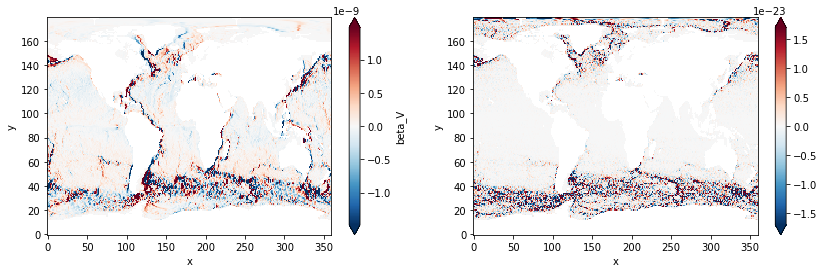

In [12]:
fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
ds_regrid_bilin1['beta_V'].plot(robust=True) # this is just noise

tmp = (ds_regrid_bilin1['beta_V'] - ds_regrid_bilin1['BPT'] - ds_regrid_bilin1['Curl_Adv'] - ds_regrid_bilin1['Curl_taus'] - ds_regrid_bilin1['Curl_taub'] 
       - ds_regrid_bilin1['Curl_diff'] - ds_regrid_bilin1['Mass_flux'] - ds_regrid_bilin1['Curl_dudt'] - ds_regrid_bilin1['eta_dt'])

plt.subplot(1,2,2)
tmp.plot(robust=True) # this is just noise

In [15]:
## Check what happens if we change lon values

grid_1x1 = xr.Dataset()
grid_1x1['lon'] = xr.DataArray(data=0.5 + np.arange(360) - 270., dims=('x'))
grid_1x1['lat'] = xr.DataArray(data=0.5 -90 + np.arange(180), dims=('y'))
grid_1x1['lon_b'] = xr.DataArray(data=np.arange(361) - 270., dims=('x_b'))
grid_1x1['lat_b'] = xr.DataArray(data=-90 + np.arange(181), dims=('y_b'))

print(grid_1x1)

<xarray.Dataset>
Dimensions:  (x: 360, y: 180, x_b: 361, y_b: 181)
Dimensions without coordinates: x, y, x_b, y_b
Data variables:
    lon      (x) float64 -269.5 -268.5 -267.5 -266.5 ... 86.5 87.5 88.5 89.5
    lat      (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    lon_b    (x_b) float64 -270.0 -269.0 -268.0 -267.0 ... 87.0 88.0 89.0 90.0
    lat_b    (y_b) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90


In [16]:
%time regrid_ds = xe.Regridder(grid_model, grid_1x1, 'bilinear', periodic=True)

CPU times: user 42.3 s, sys: 2.57 s, total: 44.9 s
Wall time: 45.4 s


In [17]:
%time ds_regrid_bilin2 = regrid_ds(ds_inp)

print(ds_regrid_bilin2)

CPU times: user 1.72 s, sys: 41.9 ms, total: 1.76 s
Wall time: 1.84 s
<xarray.Dataset>
Dimensions:    (y: 180, x: 360)
Dimensions without coordinates: y, x
Data variables:
    beta_V     (y, x) float64 nan nan nan nan ... 5.276e-12 5.196e-12 5.109e-12
    BPT        (y, x) float64 nan nan nan ... -2.427e-10 -2.257e-10 -2.122e-10
    Curl_Adv   (y, x) float64 nan nan nan ... -1.755e-10 -2.184e-10 -2.583e-10
    Curl_taus  (y, x) float64 nan nan nan nan ... 1.903e-10 1.935e-10 1.968e-10
    Curl_taub  (y, x) float64 nan nan nan nan ... 5.248e-11 5.542e-11 5.811e-11
    Curl_diff  (y, x) float64 nan nan nan nan ... 1.796e-10 1.992e-10 2.195e-10
    Mass_flux  (y, x) float64 nan nan nan nan ... 1.357e-12 1.345e-12 1.333e-12
    Curl_dudt  (y, x) float64 nan nan nan ... -2.602e-13 -1.912e-13 -1.154e-13
    eta_dt     (y, x) float64 nan nan nan ... -2.683e-15 -2.682e-15 -2.682e-15
Attributes:
    regrid_method:  bilinear


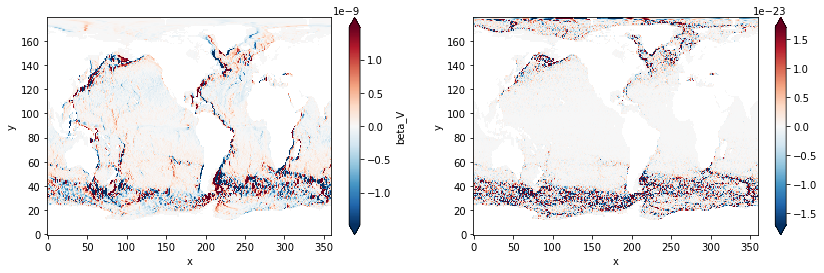

In [18]:
fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
ds_regrid_bilin2['beta_V'].plot(robust=True) # this is just noise

tmp = (ds_regrid_bilin2['beta_V'] - ds_regrid_bilin2['BPT'] - ds_regrid_bilin2['Curl_Adv'] - ds_regrid_bilin2['Curl_taus'] - ds_regrid_bilin2['Curl_taub'] 
       - ds_regrid_bilin2['Curl_diff'] - ds_regrid_bilin2['Mass_flux'] - ds_regrid_bilin2['Curl_dudt'] - ds_regrid_bilin2['eta_dt'])

plt.subplot(1,2,2)
tmp.plot(robust=True) # this is just noise

In [19]:
# Check with conservative method

ds_out = xe.util.grid_global(1., 1.) # xesmf inbuit function

%time regrid_ds = xe.Regridder(grid_model, ds_out, method="conservative", periodic=True)

CPU times: user 51.2 s, sys: 6.09 s, total: 57.3 s
Wall time: 58.2 s


In [20]:
%time ds_regrid_cons = regrid_ds(ds_inp)

print(ds_regrid_cons)

CPU times: user 808 ms, sys: 59 ms, total: 867 ms
Wall time: 944 ms
<xarray.Dataset>
Dimensions:    (y: 180, x: 360)
Coordinates:
    lat        (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon        (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: y, x
Data variables:
    beta_V     (y, x) float64 0.0 0.0 0.0 0.0 ... 3.117e-11 3.268e-11 3.418e-11
    BPT        (y, x) float64 0.0 0.0 0.0 0.0 ... 8.025e-09 6.305e-09 3.625e-09
    Curl_Adv   (y, x) float64 0.0 0.0 0.0 ... -9.742e-10 -1.894e-10 3.526e-10
    Curl_taus  (y, x) float64 0.0 0.0 0.0 ... -5.421e-10 -5.223e-10 -5.059e-10
    Curl_taub  (y, x) float64 0.0 0.0 0.0 ... -2.155e-10 -1.969e-10 -1.625e-10
    Curl_diff  (y, x) float64 0.0 0.0 0.0 ... -6.263e-09 -5.364e-09 -3.274e-09
    Mass_flux  (y, x) float64 0.0 0.0 0.0 0.0 ... 7.076e-13 7.082e-13 7.043e-13
    Curl_dudt  (y, x) float64 0.0 0.0 0.0 ... 1.757e-13 -9.014e-13 -1.117e-12
    eta_dt     (y, x) floa

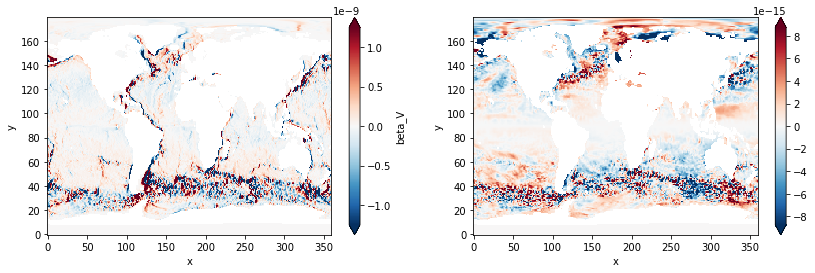

In [22]:
fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
ds_regrid_cons['beta_V'].plot(robust=True) # this is just noise

tmp = (ds_regrid_cons['beta_V'] - ds_regrid_cons['BPT'] - ds_regrid_cons['Curl_Adv'] - ds_regrid_cons['Curl_taus'] - ds_regrid_cons['Curl_taub'] 
       - ds_regrid_cons['Curl_diff'] - ds_regrid_cons['Mass_flux'] - ds_regrid_cons['Curl_dudt'] - 0*ds_regrid_cons['eta_dt'])

plt.subplot(1,2,2)
tmp.plot(robust=True) # this is just noise

In [25]:
## Try with conservative normed method

ds_out = xe.util.grid_global(1., 1.) # xesmf inbuit function

%time regrid_ds = xe.Regridder(grid_model, ds_out, method="conservative_normed", periodic=True)

CPU times: user 49.7 s, sys: 7.3 s, total: 57 s
Wall time: 57.7 s


In [26]:
%time ds_regrid_cons_norm = regrid_ds(ds_inp)

print(ds_regrid_cons_norm)

CPU times: user 755 ms, sys: 77.8 ms, total: 833 ms
Wall time: 851 ms
<xarray.Dataset>
Dimensions:    (y: 180, x: 360)
Coordinates:
    lat        (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon        (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: y, x
Data variables:
    beta_V     (y, x) float64 0.0 0.0 0.0 0.0 ... 3.117e-11 3.268e-11 3.418e-11
    BPT        (y, x) float64 0.0 0.0 0.0 0.0 ... 8.025e-09 6.305e-09 3.625e-09
    Curl_Adv   (y, x) float64 0.0 0.0 0.0 ... -9.742e-10 -1.894e-10 3.526e-10
    Curl_taus  (y, x) float64 0.0 0.0 0.0 ... -5.421e-10 -5.223e-10 -5.059e-10
    Curl_taub  (y, x) float64 0.0 0.0 0.0 ... -2.155e-10 -1.969e-10 -1.625e-10
    Curl_diff  (y, x) float64 0.0 0.0 0.0 ... -6.263e-09 -5.364e-09 -3.274e-09
    Mass_flux  (y, x) float64 0.0 0.0 0.0 0.0 ... 7.076e-13 7.082e-13 7.043e-13
    Curl_dudt  (y, x) float64 0.0 0.0 0.0 ... 1.757e-13 -9.014e-13 -1.117e-12
    eta_dt     (y, x) fl

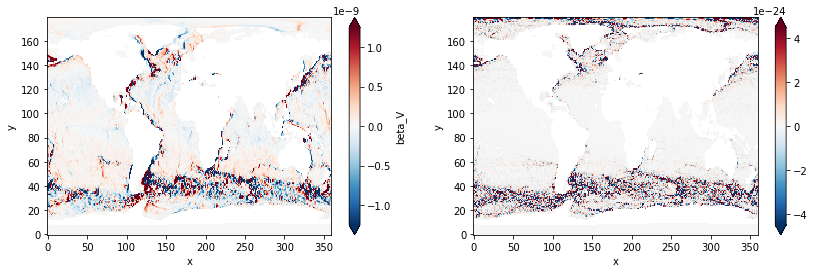

In [29]:
fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
ds_regrid_cons_norm['beta_V'].plot(robust=True, facecolor='grey') # this is just noise

tmp = (ds_regrid_cons_norm['beta_V'] - ds_regrid_cons_norm['BPT'] - ds_regrid_cons_norm['Curl_Adv'] - ds_regrid_cons_norm['Curl_taus'] - ds_regrid_cons_norm['Curl_taub'] 
       - ds_regrid_cons_norm['Curl_diff'] - ds_regrid_cons_norm['Mass_flux'] - ds_regrid_cons_norm['Curl_dudt'] - ds_regrid_cons_norm['eta_dt'])

plt.subplot(1,2,2)
tmp.plot(robust=True) # this is just noise

In [13]:
## check if regridding from q-points make any difference

ds_out = xe.util.grid_global(1., 1.) # xesmf inbuit function

ds_tmp = ds.get(var_list)
ds_tmp = xr.merge([ds_tmp, ds.get(['geolon_c', 'geolat_c'])])

ds_tmp = ds_tmp.rename({'geolon_c': 'lon','geolat_c': 'lat'})

print(ds_tmp)

%time regrid_ds = xe.Regridder(ds_tmp, ds_out, method="bilinear", periodic=True)

<xarray.Dataset>
Dimensions:    (yq: 1080, xq: 1440)
Coordinates:
  * xq         (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq         (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    beta_V     (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    BPT        (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_Adv   (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_taus  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_taub  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_diff  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Mass_flux  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_dudt  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    eta_dt     (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    lon        (yq, xq) float32 ...
    lat

CPU times: user 2.17 s, sys: 72.3 ms, total: 2.24 s
Wall time: 2.46 s
<xarray.Dataset>
Dimensions:    (y: 180, x: 360)
Coordinates:
    lon        (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat        (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
Dimensions without coordinates: y, x
Data variables:
    beta_V     (y, x) float64 nan nan nan nan ... 6.46e-12 7.165e-12 7.841e-12
    BPT        (y, x) float64 nan nan nan nan ... 1.592e-09 1.363e-09 1.181e-09
    Curl_Adv   (y, x) float64 nan nan nan nan ... 1.54e-09 3.482e-10 -8.819e-10
    Curl_taus  (y, x) float64 nan nan nan ... -6.165e-10 -6.287e-10 -6.408e-10
    Curl_taub  (y, x) float64 nan nan nan nan ... -5.234e-10 -4.39e-10 -3.55e-10
    Curl_diff  (y, x) float64 nan nan nan nan ... -1.993e-09 -6.44e-10 6.97e-10
    Mass_flux  (y, x) float64 nan nan nan nan ... 9.658e-13 9.563e-13 9.47e-13
    Curl_dudt  (y, x) float64 nan nan nan nan ... 6.609e-12 6.713e-12 6.848e-12
    eta_dt     (y, 

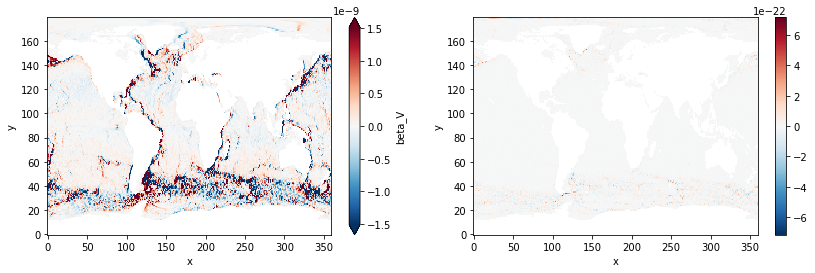

In [15]:
## It doesn't matter if the data is regridded from q-points or tracer points

%time ds_regrid = regrid_ds(ds_tmp)

print(ds_regrid)

fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
ds_regrid['beta_V'].plot(robust=True, facecolor='grey') # this is just noise

tmp = (ds_regrid['beta_V'] - ds_regrid['BPT'] - ds_regrid['Curl_Adv'] - ds_regrid['Curl_taus'] - ds_regrid['Curl_taub'] 
       - ds_regrid['Curl_diff'] - ds_regrid['Mass_flux'] - ds_regrid['Curl_dudt'] - ds_regrid['eta_dt'])

plt.subplot(1,2,2)
tmp.plot() # this is just noise

### Re-gridding used

Based on the tests above. both 'bilinear and 'conserved' methods work well. The budget is closed in the regidded data. For coarse-graining, we regrid vortiticy fields using 'conservative' method on 0.25x0.25 grid. 

In [50]:
ds_out = xe.util.grid_global(0.25, 0.25) # xesmf inbuit function

%time regrid_ds = xe.Regridder(grid_model, ds_out, method="conservative", periodic=True)

CPU times: user 1min 27s, sys: 8.22 s, total: 1min 35s
Wall time: 1min 36s


In [51]:
%time ds_regrid_cons = regrid_ds(ds_inp) # skipna=True)

print(ds_regrid_cons)

CPU times: user 1.24 s, sys: 43.7 ms, total: 1.28 s
Wall time: 1.28 s
<xarray.Dataset>
Dimensions:    (y: 720, x: 1440)
Coordinates:
    lat        (y, x) float64 -89.88 -89.88 -89.88 -89.88 ... 89.88 89.88 89.88
    lon        (y, x) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Dimensions without coordinates: y, x
Data variables:
    beta_V     (y, x) float64 0.0 0.0 0.0 ... -7.817e-13 -7.705e-13 -7.596e-13
    BPT        (y, x) float64 0.0 0.0 0.0 0.0 ... 6.378e-10 6.114e-10 5.856e-10
    Curl_Adv   (y, x) float64 0.0 0.0 0.0 0.0 ... 1.572e-10 1.513e-10 1.455e-10
    Curl_taus  (y, x) float64 0.0 0.0 0.0 ... -2.438e-10 -2.461e-10 -2.483e-10
    Curl_taub  (y, x) float64 0.0 0.0 0.0 ... -6.189e-11 -6.266e-11 -6.345e-11
    Curl_diff  (y, x) float64 0.0 0.0 0.0 ... -5.007e-10 -4.653e-10 -4.308e-10
    Mass_flux  (y, x) float64 0.0 0.0 0.0 0.0 ... 1.364e-12 1.364e-12 1.364e-12
    Curl_dudt  (y, x) float64 0.0 0.0 0.0 0.0 ... 9.231e-12 9.263e-12 9.294e-12
    eta_dt     (y,

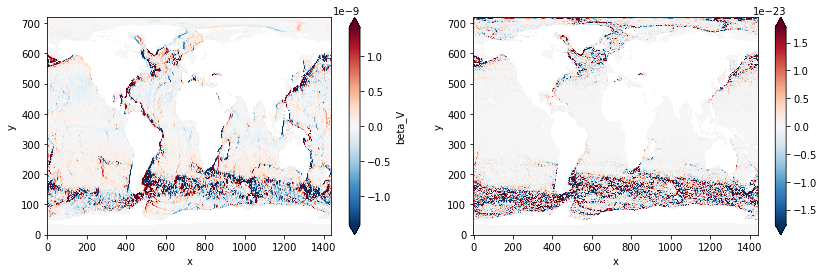

In [52]:
fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
ds_regrid_cons['beta_V'].plot(robust=True) # this is just noise

tmp = (ds_regrid_cons['beta_V'] - ds_regrid_cons['BPT'] - ds_regrid_cons['Curl_Adv'] - ds_regrid_cons['Curl_taus'] - ds_regrid_cons['Curl_taub'] 
       - ds_regrid_cons['Curl_diff'] - ds_regrid_cons['Mass_flux'] - ds_regrid_cons['Curl_dudt'] - ds_regrid_cons['eta_dt'])

plt.subplot(1,2,2)
tmp.plot(robust=True) # this is just noise

In [53]:
ds_regrid_cons.coords['x'] = ds_regrid_cons.lon.values[0,:]
ds_regrid_cons.coords['y'] = ds_regrid_cons.lat.values[:,0]

ds_regrid_cons = ds_regrid_cons.fillna(-999999.) # replace nan with fillvalue

print(ds_regrid_cons)

<xarray.Dataset>
Dimensions:    (y: 720, x: 1440)
Coordinates:
    lat        (y, x) float64 -89.88 -89.88 -89.88 -89.88 ... 89.88 89.88 89.88
    lon        (y, x) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * x          (x) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * y          (y) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
Data variables:
    beta_V     (y, x) float64 0.0 0.0 0.0 ... -7.817e-13 -7.705e-13 -7.596e-13
    BPT        (y, x) float64 0.0 0.0 0.0 0.0 ... 6.378e-10 6.114e-10 5.856e-10
    Curl_Adv   (y, x) float64 0.0 0.0 0.0 0.0 ... 1.572e-10 1.513e-10 1.455e-10
    Curl_taus  (y, x) float64 0.0 0.0 0.0 ... -2.438e-10 -2.461e-10 -2.483e-10
    Curl_taub  (y, x) float64 0.0 0.0 0.0 ... -6.189e-11 -6.266e-11 -6.345e-11
    Curl_diff  (y, x) float64 0.0 0.0 0.0 ... -5.007e-10 -4.653e-10 -4.308e-10
    Mass_flux  (y, x) float64 0.0 0.0 0.0 0.0 ... 1.364e-12 1.364e-12 1.364e-12
    Curl_dudt  (y, x) float64 0.0 0.0 0.0 0.0 ... 9

In [54]:
save_file = "OM4p25_JRA55_Vorticity_Budget_Regrid_LatLon.nc"

for var in list(ds_regrid_cons.keys()):
    
    ds_regrid_cons[var].encoding['_FillValue'] = -999999.

%time (ds_regrid_cons).to_netcdf(ppdir + save_file)

CPU times: user 57.9 ms, sys: 102 ms, total: 160 ms
Wall time: 280 ms
